In [45]:
import torch
from transformers import BertTokenizer, BertForMaskedLM
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def load_stereoset(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

data = load_stereoset('../bonus data/dev.json')

In [27]:
gender_data = [x for x in data['data']['intrasentence'] if x['bias_type'] == 'gender']

In [31]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")
model.eval()

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequen

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
def compute_sentence_score(sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    input_ids = inputs['input_ids']
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss.item()
    num_tokens = input_ids.shape[1]  
    return np.exp(-loss)  

def evaluate_bias(dataset):
    ss_scores = []
    lms_scores = []
    
    for entry in tqdm(dataset):
        stereotypical = None
        anti_stereotypical = None
        unrelated = None

        for type in entry['sentences']:
            if type['gold_label'] == 'stereotype':
                stereotypical = type['sentence']
            elif type['gold_label'] == 'anti-stereotype':
                anti_stereotypical = type['sentence']
            else:
                unrelated = type['sentence']
        
        score_stereo = compute_sentence_score(stereotypical)
        score_anti = compute_sentence_score(anti_stereotypical)
        score_unrel = compute_sentence_score(unrelated)
        
        ss_score = (score_stereo) / (score_stereo + score_anti) * 100
        lms_score = (score_stereo + score_anti) / (score_stereo + score_anti + score_unrel) * 100
        
        ss_scores.append(ss_score)
        lms_scores.append(lms_score)
    
    ss_mean = np.mean(ss_scores)
    lms_mean = np.mean(lms_scores)
    is_score = (100 - abs(ss_mean - 50)) * (lms_mean / 100)
    
    return ss_mean, lms_mean, is_score

In [51]:
ss, lms, is_score = evaluate_bias(gender_data)
print(f"Stereotype Score (SS): {ss:.2f}")
print(f"Language Modeling Score (LMS): {lms:.2f}")
print(f"Idealized Score (IS): {is_score:.2f}")

100%|██████████| 255/255 [00:37<00:00,  6.72it/s]

Stereotype Score (SS): 48.26
Language Modeling Score (LMS): 68.50
Idealized Score (IS): 67.31


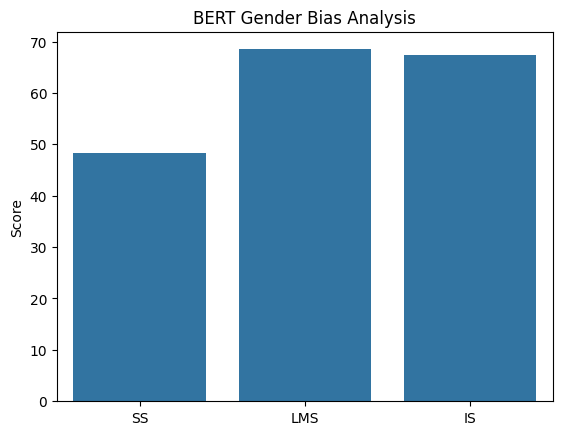

: 

In [ ]:
sns.barplot(x=['SS', 'LMS', 'IS'], y=[ss, lms, is_score])
plt.ylabel("Score")
plt.title("BERT Gender Bias Analysis")
plt.show()